<a href="https://colab.research.google.com/github/farenga/meshgnn/blob/main/meshGNN-reg-voronoi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
import torch

def format_pytorch_version(version):
  return version.split('+')[0]

TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)

def format_cuda_version(version):
  return 'cu' + version.replace('.', '')

CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html
Looking in links: https://data.pyg.org/whl/torch-1.10.0+cu111.html


In [185]:
import numpy as np
import torch_geometric
from torch_geometric.data import Data
import matplotlib.pyplot as plt
import scipy.io
import networkx as nx

In [186]:
from google.colab import drive
drive.mount('/gdrive')

%cd /gdrive/MyDrive/University/Courses/NAPDE-Project/data
%ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive/University/Courses/NAPDE-Project/data
AdiacencyMatrices_square.mat   AreaVectors_voronoi.mat
AdiacencyMatrices_voronoi.mat  CoordMatrices_square.mat
AreaVectors_square.mat         CoordMatrices_voronoi.mat


In [187]:
dataset_type = 'voronoi'

if dataset_type=='square':
  areas = torch.tensor(scipy.io.loadmat('AreaVectors_square.mat')['AreaVectors'],dtype=torch.float)
  coords = torch.tensor(scipy.io.loadmat('CoordMatrices_square.mat')['CoordMatrices'],dtype=torch.float)
  adjacencies = torch.tensor(scipy.io.loadmat('AdiacencyMatrices_square.mat')['AdiacencyMatrices'])
  areas = areas.unsqueeze(-1)
  coords = coords.unsqueeze(-1)
  adjacencies = adjacencies.unsqueeze(-1)

if dataset_type=='voronoi':
  areas = torch.tensor(scipy.io.loadmat('AreaVectors_voronoi.mat')['AreaVectors'],dtype=torch.float)
  coords = torch.tensor(scipy.io.loadmat('CoordMatrices_voronoi.mat')['CoordMatrices'],dtype=torch.float)
  adjacencies = torch.tensor(scipy.io.loadmat('AdiacencyMatrices_voronoi.mat')['AdiacencyMatrices'])
  

In [188]:
sample_idx = 0
x = torch.cat([coords[:,:,sample_idx],areas[:,:,sample_idx]],-1)
A = adjacencies[:,:,sample_idx]
edge_index = (A > 0).nonzero().t()
data = Data(x=x, edge_index=edge_index)

In [189]:
print('DATA SUMMARY\n')
print(data)
print('----------------------------------------')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

DATA SUMMARY

Data(x=[50, 3], edge_index=[2, 246])
----------------------------------------
Number of nodes: 50
Number of edges: 246
Average node degree: 4.92


In [239]:
import torch.nn as nn
from torch_geometric.nn import SAGEConv
from torch_geometric.utils import softmax


class GCN(torch.nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        torch.manual_seed(123)
        self.convIn = SAGEConv(3, hidden_units)
        self.conv2 = SAGEConv(hidden_units, hidden_units)
        self.conv3 = SAGEConv(hidden_units, hidden_units)
        self.convOut = SAGEConv(hidden_units, 2)

    def forward(self, x, edge_index):
        x = self.convIn(x, edge_index)
        x = x.tanh()
        x = self.conv2(x, edge_index)
        x = x.tanh()
        x = self.conv3(x, edge_index)
        x = x.tanh()
        x = self.convOut(x, edge_index)
        #x = torch.nn.functional.softmax(x)
        x = nn.Softmax(dim=1)(x)
        return x

model = GCN(hidden_units=32)
print(model)

GCN(
  (convIn): SAGEConv(3, 32)
  (conv2): SAGEConv(32, 32)
  (conv3): SAGEConv(32, 32)
  (convOut): SAGEConv(32, 2)
)


In [240]:
from torch_geometric.utils import degree
def loss_normalized_cut(y,graph):
  d=degree(graph.edge_index[0],num_nodes = y.size(0))
  gamma = torch.t( y) @ d
  c = torch.sum(y[ graph.edge_index[0],0]*y[graph.edge_index[1],1])
  
  outclass = torch.tensor(y>=.5,dtype=torch.float)
  areas = torch.matmul(graph.x[:,-1].t(),outclass)

  return torch.sum(torch.div(c,gamma)) + 0.5*torch.abs(areas[0]-areas[1])

In [241]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
#criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()
      
      sample_idx_rnd = np.random.randint(0,adjacencies.shape[-1])
      x = torch.cat([coords[:,:,sample_idx_rnd],areas[:,:,sample_idx_rnd]],-1)
      A = adjacencies[:,:,sample_idx_rnd]
      edge_index = (A > 0).nonzero().t()
      data = Data(x=x, edge_index=edge_index)
      out = model(data.x, data.edge_index)  
      loss = loss_normalized_cut(out, data )  
      loss.backward()  
      optimizer.step()  
      return loss

loss_array = []
for epoch in range(1, 3000+1):
    loss = train()
    loss_array.append(loss.item())
    if epoch==1 or epoch%200==0:
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys


Epoch: 001, Loss: 1.3447
Epoch: 200, Loss: 0.4658
Epoch: 400, Loss: 0.6322
Epoch: 600, Loss: 0.2803
Epoch: 800, Loss: 0.3016
Epoch: 1000, Loss: 0.3579
Epoch: 1200, Loss: 0.1843
Epoch: 1400, Loss: 0.2801
Epoch: 1600, Loss: 0.3492
Epoch: 1800, Loss: 0.2845
Epoch: 2000, Loss: 0.2692
Epoch: 2200, Loss: 0.2184
Epoch: 2400, Loss: 0.2481
Epoch: 2600, Loss: 0.2369
Epoch: 2800, Loss: 0.2738
Epoch: 3000, Loss: 0.2689


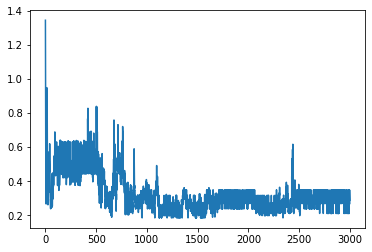

In [242]:
plt.plot(loss_array)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # This is added back by InteractiveShellApp.init_path()



Sample Index:  7
Area1:  0.5302595496177673   |  Area2:  0.46974045038223267 



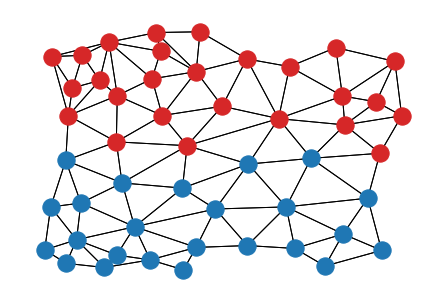

In [250]:
model.eval()
sample_idx = np.random.randint(0,adjacencies.shape[-1])

x_test = torch.cat([coords[:,:,sample_idx],areas[:,:,sample_idx]],-1)
A_test = adjacencies[:,:,sample_idx]
edge_index_test = (A_test > 0).nonzero().t()
data_test = Data(x=x_test, edge_index=edge_index_test)

out = model(data_test.x, data_test.edge_index)

outclass = torch.tensor(out>=.5,dtype=torch.bool)
class1 = outclass[:,0]
class2 = outclass[:,1]  
class1_idx = np.transpose(np.nonzero(class1))[0]
class2_idx = np.transpose(np.nonzero(class2))[0]
g = torch_geometric.utils.to_networkx(data_test, to_undirected=True)
nx.draw(g,coords[:,:,sample_idx].tolist(),nodelist=class1_idx.tolist(), node_color="tab:red")
nx.draw(g,coords[:,:,sample_idx].tolist(),nodelist=class2_idx.tolist(), node_color="tab:blue")

# Areas
areas_class1 = areas[class1,:,sample_idx]
areas_class2 = areas[class2,:,sample_idx]
area1 = sum(areas_class1)
area2 = sum(areas_class2)
print('\nSample Index: ', sample_idx)
print('Area1: ', area1.item(),'  |  Area2: ', area2.item(),'\n')
